<a href="https://colab.research.google.com/github/ReneeZhang2017/Animation/blob/master/Big_Data_Homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ingest

In [0]:
import pandas as pd

In [0]:
df = pd.read_csv("https://gist.githubusercontent.com/mbostock/9535021/raw/902265051e775cd35a6aa6307a23070f739ebed1/us-state-capitals.csv")

In [0]:
df.head()

,name,description,latitude,longitude
0,Alabama,Montgomery,32.377716,-86.300568
1,Alaska,Juneau,58.301598,-134.420212
2,Arizona,Phoenix,33.448143,-112.096962
3,Arkansas,Little Rock,34.746613,-92.288986
4,California,Sacramento,38.576668,-121.493629


#Create necessary classes and functions

##Convert lat/long to x y coordinates in km

In [0]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [0]:
df['xprepare'] = (df['longitude']+ 86.300568)*40000

In [0]:
df['xcoordinate'] = 0

In [0]:
for i in range(0,len(df)-1):
  df.xcoordinate.loc[i]= df.xprepare.loc[i]*math.cos((df.latitude.loc[i]+32.377716)*math.pi/360)/360

df.xcoordinate

In [0]:
df['ycoordinate'] = (df['latitude']-32.377716)*40000/360

In [0]:
df.head()

,name,description,latitude,longitude,xprepare,xcoordinate,ycoordinate
0,Alabama,Montgomery,32.377716,-86.300568,0.00,0.000000,0.000000
1,Alaska,Juneau,58.301598,-134.420212,-1924785.76,-3758.157873,2880.431333
2,Arizona,Phoenix,33.448143,-112.096962,-1031855.76,-2406.222480,118.936333
3,Arkansas,Little Rock,34.746613,-92.288986,-239536.72,-554.451982,263.210778
4,California,Sacramento,38.576668,-121.493629,-1407722.44,-3184.372241,688.772444


##Create class to handle "cities"

In [0]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

##Create cityList containing lat/long for US state capitols

In [0]:
cityList = []

for i in range(0,len(df)):
    cityList.append(City(x = round(float(df.iloc[i,[5]]),2), y = round(float(df.iloc[i,[6]]),2)))

In [0]:
cityList

##Create a fitness function

In [0]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

#Create our initial population

##Route generator

In [0]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

##Create first "population" (list of routes)

In [0]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

#Create the genetic algorithm

##Rank individuals

In [0]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

##Create a selection function that will be used to make the list of parent routes

In [0]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

##Create mating pool

In [0]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

##Create a crossover function for two parents to create one child

In [0]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

##Create function to run crossover over full mating pool

In [0]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

##Create function to mutate a single route

In [0]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

##Create function to run mutation over entire population

In [0]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

##Put all steps together to create the next generation

In [0]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

##Final step: create the genetic algorithm

In [0]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

#Running the genetic algorithm

In [0]:
geneticAlgorithm(population=cityList, popSize=200, eliteSize=20, mutationRate=0.01, generations=500)

Initial distance: 77848.07457952513
Final distance: 41477.90311739418


[(191.49,-215.51),
 (705.08,378.08),
 (-44.41,420.9),
 (424.84,662.06),
 (971.95,753.29),
 (1319.09,1050.36),
 (1345.51,1108.94),
 (1196.02,1320.52),
 (1439.56,1325.49),
 (1207.33,1042.93),
 (1105.42,1141.68),
 (1296.22,1203.24),
 (885.38,733.45),
 (0.0,0.0),
 (178.07,152.37),
 (129.27,645.45),
 (843.04,876.3),
 (1032.55,871.43),
 (807.45,573.46),
 (296.14,842.63),
 (153.73,1150.66),
 (0.0,973.62),
 (-590.08,1397.49),
 (-301.19,824.52),
 (-364.38,-8.21),
 (-463.38,-213.41),
 (-2406.22,118.94),
 (-1808.43,367.17),
 (-2283.13,933.31),
 (-3186.87,1395.64),
 (-2617.95,1248.9),
 (-3016.96,754.02),
 (-7094.07,-1230.03),
 (-3758.16,2880.43),
 (-3128.97,1628.68),
 (-3184.37,688.77),
 (-2205.53,1578.67),
 (-1678.3,817.95),
 (-1239.92,1604.79),
 (-1223.54,1332.15),
 (-648.2,1023.71),
 (-554.45,263.21),
 (12.39,821.21),
 (-271.02,1188.55),
 (-1032.74,346.05),
 (-846.0,741.16),
 (-1085.79,-233.67),
 (-927.7,936.71),
 (-531.34,689.05),
 (489.79,180.29)]

#Plot the progress

In [0]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    print ("Best-route generation : " + str(progress.index(min(progress))))
    print ("Best-route distance : " + str(min(progress)))
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

Best-route generation : 218
Best-route distance : 42390.52141696625


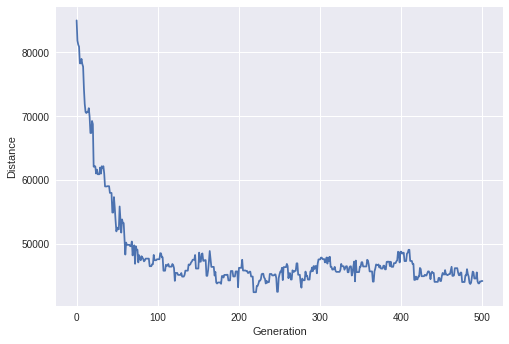

In [0]:
geneticAlgorithmPlot(population=cityList, popSize=200, eliteSize=20, mutationRate=0.01, generations=500)